In [18]:
## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

SimpleITK Version: 0.9.1
Compiled: Sep 28 2015 10:07:41



In [19]:
import scipy.io
import numpy as np
from itertools import product
from sklearn.neighbors import KNeighborsClassifier

In [20]:
OUT_DIR='/raid0/homes/aghayoor/Desktop/phantom'
write_to_disk=False
verbose=False

In [21]:
def CreateFirstModality(write):
    t1=sitk.Image(128,128,sitk.sitkUInt8)
    #
    t1_arr=sitk.GetArrayFromImage(t1)
    t1_arr[12:67,43:122]=50 # tissue A or c
    t1_arr[67:80,85:122]=50 # tissue A or C
    t1_arr[12:25,43:55]=0
    t1_arr[54:60,112:122]=0
    t1_arr[46:55,52:77]=250 # B
    t1_arr[55:65,67:77]=250 # B
    t1_arr[65:119,8:85]=250 # tissue B
    t1_arr[100:123,65:123]=0
    t1_arr[87:100,73:123]=0
    t1_arr[65:79,32:38]=0
    t1_arr[100:107,8:21]=0
    t1_arr[108:119,41:48]=0
    t1_arr[114:119,0:31]=0
    #
    t1=sitk.GetImageFromArray(t1_arr)
    if write:
        sitk.WriteImage(t1,os.path.join(OUT_DIR,'t1.nii.gz'))
        scipy.io.savemat(os.path.join(OUT_DIR,'t1.mat'), mdict={'t1': t1_arr})
    return t1

def CreatSecondModality(write):
    t2=sitk.Image(128,128,sitk.sitkUInt8)
    #
    t2_arr=sitk.GetArrayFromImage(t2)    
    t2_arr[12:67,43:122]=200 # tissue A or c
    t2_arr[67:80,85:122]=200 # tissue A or C
    t2_arr[12:25,43:55]=0
    t2_arr[46:55,52:77]=100 # B
    t2_arr[55:65,67:77]=100 # B
    t2_arr[65:119,8:85]=100 # tissue B
    t2_arr[100:123,65:123]=0
    t2_arr[87:100,73:123]=0
    t2_arr[65:79,32:38]=0
    t2_arr[100:107,8:21]=0
    t2_arr[108:119,41:48]=0
    t2_arr[114:119,0:31]=0
    t2_arr[31:80,85:122]=150 # tissue C
    t2_arr[31:53,85:107]=200 # tissue A
    t2_arr[54:60,112:122]=0
    #
    t2=sitk.GetImageFromArray(t2_arr)
    if write:
        sitk.WriteImage(t2,os.path.join(OUT_DIR,'t2.nii.gz'))
        scipy.io.savemat(os.path.join(OUT_DIR,'t2.mat'), mdict={'t2': t2_arr})
    return t2

def CreateWholeOneMask(size):
    onemask = sitk.Image(size,sitk.sitkUInt8)
    onemask_arr = sitk.GetArrayFromImage(onemask)
    onemask_arr.fill(1)
    onemask = sitk.GetImageFromArray(onemask_arr)
    return onemask

def DownsampleSecondModality(t2, factor, write):
    t2_lr = sitk.Shrink(t2,[factor,factor])
    if write:
        sitk.WriteImage(t2_lr,os.path.join(OUT_DIR,'t2_lr.nii.gz'))
        t2_lr_arr=sitk.GetArrayFromImage(t2_lr)
        scipy.io.savemat(os.path.join(OUT_DIR,'t2_lr.mat'), mdict={'t2_lr': t2_lr_arr})
    return t2_lr

def UpsampleSecondModality(t_lr, f, write):
    factor=np.array([f, f])
    filt=sitk.ResampleImageFilter()
    outSpacing=t_lr.GetSpacing()/factor
    outSize=t_lr.GetSize()*factor
    filt.SetInterpolator(sitk.sitkLinear)
    filt.SetOutputSpacing(outSpacing)
    filt.SetSize(outSize)
    t_up = filt.Execute(t_lr)
    if write:
        sitk.WriteImage(t_up,os.path.join(OUT_DIR,'t2_up.nii.gz'))
        t_up_arr=sitk.GetArrayFromImage(t_up)
        scipy.io.savemat(os.path.join(OUT_DIR,'t2_up.mat'), mdict={'t2_up': t_up_arr})
    return t_up

def ResampleImageToRefImage(t_in, t_ref):
    filt=sitk.ResampleImageFilter()
    filt.SetInterpolator(sitk.sitkLinear)
    filt.SetReferenceImage(t_ref)
    t_out = filt.Execute(t_in)
    return t_out

def CreatePurePlugsMask(t1,t2_lr,write,verbose):
    #################
    def isPurePlug(idx, t2_lr, t1):
        hspc=np.array(t2_lr.GetSpacing())
        lspc=np.array(t1.GetSpacing())
        factor=hspc/lspc
        hResSize = t1.GetSize()
        # continues index
        cidx=np.array([float(i) for i in idx])
        if verbose:
            print('----------------------------')
            print("index: {0}".format(cidx)) # <-----
        p = t2_lr.TransformContinuousIndexToPhysicalPoint(cidx)
        if verbose:
            print(p)
        #
        isInside = True
        t1_sampleValues=[]
        #
        margin=0.05     
        begin_i=cidx[0]-0.5+margin; end_i=cidx[0]+0.5-margin+0.001; 
        if factor[0] == 1:
            step_i=(1-2*margin)/(factor[0])
        else:
            step_i=(1-2*margin)/(factor[0]-1)
        begin_j=cidx[1]-0.5+margin; end_j=cidx[1]+0.5-margin+0.001; 
        if factor[1] == 1:
            step_j=(1-2*margin)/(factor[1])
        else:
            step_j=(1-2*margin)/(factor[1]-1)
        #
        for iss in np.arange(begin_i,end_i,step_i):
            for jss in np.arange(begin_j,end_j,step_j):
                cssidx=[iss, jss]
                #
                if verbose:
                    print("continus subsample: {0}".format(cssidx)) # <-----
                #
                p = t2_lr.TransformContinuousIndexToPhysicalPoint(cssidx)
                #
                if verbose:
                    print("point: {0}".format(p)) # <-----
                #
                newidx = t1.TransformPhysicalPointToIndex(p)
                #
                if verbose:
                    print("newidx: {0}".format(newidx)) # <-----
                #
                if any( newidx[i] < 0 or newidx[i] >= hResSize[i] for i in range(len(newidx))):
                    isInside = False
                    #
                    if verbose:
                        print("is not inside") # <-----
                    #
                    break
                else:
                    t1_value = t1[newidx]
                    t1_sampleValues.append(t1_value)
            else:
                continue
            break

        ispure = False
        if isInside:
            #
            if verbose:
                print("sample values: ") # <-----
                print(t1_sampleValues) # <-----
            #
            t1_arr = np.array(t1_sampleValues)
            # check to see wether the variance is zero
            # In this case, surely we have a pure plug
            var_t1 = np.var(t1_arr)
            #
            if verbose:
                print("var: {0}".format(var_t1)) # <-----
            #
            if var_t1 == 0: # it means that the std in at least one image is zero 
                ispure = True
            else:
                ispure = False
        #
        if verbose:
            print("Is pure: {0}".format(ispure)) # <-----
        #
        return ispure
    #################
    purePlugsMask = sitk.Image(t2_lr.GetSize(),sitk.sitkUInt8)
    purePlugsMask.CopyInformation(t2_lr)
    t2_lr_size = t2_lr.GetSize()
    for i in range(0,t2_lr_size[0]):
          for j in range(0,t2_lr_size[1]):
                idx=[i,j]
                if( isPurePlug(idx,t2_lr,t1) ):
                    purePlugsMask[idx] = 1
                else:
                    purePlugsMask[idx] = 0
    if write:
        sitk.WriteImage(purePlugsMask,os.path.join(OUT_DIR,'pureplugs_mask.nii.gz'))
    return purePlugsMask

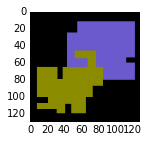

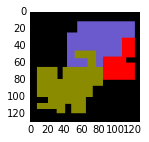

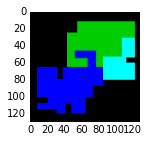

In [22]:
t1 = CreateFirstModality(write_to_disk)
t2 = CreatSecondModality(write_to_disk)
myshow(sitk.LabelToRGB(t1))
myshow(sitk.LabelToRGB(t2))
#
# segemntation baseline
seg_mask=(t2==200)*1+(t2==150)*3+(t2==100)*2
myshow(sitk.LabelToRGB(seg_mask))

In [23]:
#
#
# KNN
#
#

In [24]:
def AppendTrainingSamples(t1,t2_lr,mask,sample_num,trainSampleSet,trainLabels):
    count_b=0; count_1=0; count_2=0; count_3=0
    while( count_b < sample_num or count_1 < sample_num or count_2 < sample_num or count_3 < sample_num):
        index = np.random.randint(t1.GetSize()[0],size=(1,2))
        idx = [index[0,0].item(),index[0,1].item()]
        t1_value = t1[idx]
        p = t1.TransformIndexToPhysicalPoint(idx)
        t2_lr_idx = t2_lr.TransformPhysicalPointToIndex(p)
        if any( t2_lr_idx[i] < 0 or t2_lr_idx[i] >= t2_lr.GetSize()[i] for i in range(len(t2_lr_idx))):
            continue
        t2_lr_value = t2_lr[t2_lr_idx]
        isPure = mask[t2_lr_idx]
        if (not isPure):
            continue
        if (t2_lr_value == 0):
            if count_b >= sample_num:
                continue
            label=0
            count_b += 1
        elif (t2_lr_value == 200):
            if count_1 >= sample_num:
                continue
            label=1
            count_1 += 1
        elif (t2_lr_value == 100):
            if count_2 >= sample_num:
                continue
            label=2
            count_2 += 1
        elif (t2_lr_value == 150):
            if count_3 >= sample_num:
                continue
            label=3
            count_3 += 1
        else:
            raise ValueError('ERROR!!! invalid lable {0}'.format(t2_lr_value))
        trainSampleSet.append([t1_value,t2_lr_value])
        trainLabels.append(label)
    #print(count_b)
    #print(count_1)
    #print(count_2)
    #print(count_3)

def RunKNN(t1,t2_lr,mask,n_neighbors,sample_num_pure,sample_num_nonpure):
    weights='distance'
    algorithm='kd_tree'
    neigh = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm)
    #
    trainSampleSet=[]
    trainLabels=[]
    AppendTrainingSamples(t1,t2_lr,mask,sample_num_pure,trainSampleSet,trainLabels)
    if sample_num_nonpure > 0:
        AppendTrainingSamples(t1,t2_lr,(1-mask),sample_num_nonpure,trainSampleSet,trainLabels)
    #print(trainSampleSet)
    #print(trainLabels)
    neigh.fit(trainSampleSet, trainLabels)
    #
    out_seg = sitk.Image(t1.GetSize(),sitk.sitkUInt8)
    notdefined_samples = sitk.Image(t1.GetSize(),sitk.sitkUInt8)
    for i in range(0,t1.GetSize()[0]):
        for j in range(0,t1.GetSize()[1]):
            idx=[i,j]
            t1_value=t1[idx]
            p = t1.TransformIndexToPhysicalPoint(idx)
            t2_lr_idx = t2_lr.TransformPhysicalPointToIndex(p)
            if any( t2_lr_idx[i] < 0 or t2_lr_idx[i] >= t2_lr.GetSize()[i] for i in range(len(t2_lr_idx))):
                out_seg[idx]=0
                continue
            t2_lr_value = t2_lr[t2_lr_idx]
            testSample = [[t1_value,t2_lr_value]]
            #notdefined = not ( (t1_value==50 and t2_lr_value==200) or 
            #            (t1_value==250 and t2_lr_value==100) or
            #            (t1_value==50 and t2_lr_value==150) or
            #            (t1_value==0 and t2_lr_value==0) )
            #notdefined_samples[idx] = notdefined
            out_seg[idx] = neigh.predict(testSample).item()
    return out_seg, notdefined_samples

In [25]:
#verbose=False
n_neighbors=20
statsList=[]
total=128*128
for dfactor in xrange(1,11):
    print('-----')
    print(dfactor)
    if dfactor == 1: # verifid by experiments, here we save time
        statsList.append([dfactor,0.0,0.0,0.0])
        continue
    t2_lr = DownsampleSecondModality(t2, dfactor, write_to_disk)
    if verbose:
        myshow(sitk.LabelToRGB(t2_lr))
    #
    purePlugsMask = CreatePurePlugsMask(t1, t2_lr, write_to_disk, False)
    if verbose:
        myshow(purePlugsMask)
    #
    # First run without using pureplugsmask
    #onemask = CreateWholeOneMask(t2_lr.GetSize())
    out_seg1, notdefined_samples = RunKNN(t1,t2_lr,purePlugsMask,n_neighbors,20,10)
    #
    #stats_n=sitk.StatisticsImageFilter()
    #stats_n.Execute(notdefined_samples)
    #notdefinedcount=stats_n.GetSum()
    #print(notdefinedcount)
    #
    if verbose:
        myshow(sitk.LabelToRGB(out_seg1))
    diff1=abs(seg_mask-out_seg1)>0
    if verbose:
        myshow(diff1)
    stats1=sitk.StatisticsImageFilter()
    stats1.Execute(diff1)
    error_old=stats1.GetSum()
    print(error_old)
    #
    ## Now run using pureplugsmask
    out_seg2, notdefined_samples = RunKNN(t1,t2_lr,purePlugsMask,n_neighbors,30,0)
    #
    #stats_n=sitk.StatisticsImageFilter()
    #stats_n.Execute(notdefined_samples)
    #notdefinedcount=stats_n.GetSum()
    #
    if verbose:
        myshow(sitk.LabelToRGB(out_seg2))
    diff2=abs(seg_mask-out_seg2)>0
    if verbose:
        myshow(diff2)
    stats2=sitk.StatisticsImageFilter()
    stats2.Execute(diff2)
    error_new=stats2.GetSum()
    print(error_new)
    #
    seg_nn = UpsampleSecondModality(t2_lr, dfactor, write_to_disk)
    seg_nn = ResampleImageToRefImage(seg_nn,t2)
    seg_mask_nn=(seg_nn==200)*1+(seg_nn==150)*3+(seg_nn==100)*2
    diff_nn=abs(seg_mask-seg_mask_nn)>0
    if verbose:
        myshow(diff_nn)
    stats_nn=sitk.StatisticsImageFilter()
    stats_nn.Execute(diff_nn)
    error_nn=stats_nn.GetSum()
    print(error_nn)
    #statsList.append([dfactor,(error_old/total)*100,(error_new/total)*100,(notdefinedcount/total)*100])
    statsList.append([dfactor,(error_old/total)*100,(error_new/total)*100,(error_nn/total)*100])

-----
1
-----
2
368.0
234.0
931.0
-----
3
501.0
400.0
1117.0
-----
4
598.0
465.0
2004.0
-----
5
898.0
608.0
2341.0
-----
6
894.0
657.0
2881.0
-----
7
1136.0
940.0
3216.0
-----
8
1375.0
1006.0
3403.0
-----
9
1474.0
1043.0
3736.0
-----
10
1415.0
1237.0
3871.0


In [9]:
def writeOutputFile(filename,dataList):
    import csv
    with open(filename, 'w') as lf:
        #headerdata = [['#factor','old_method','new_method','nearest_neighbor']]
        wr = csv.writer(lf, delimiter=',')
        #wr.writerows(headerdata)
        wr.writerows(dataList)
        
csv_fn = os.path.join(OUT_DIR,'stats.csv')
writeOutputFile(csv_fn,statsList)

In [10]:
# plot the output diagram
import pandas as pd
from ggplot import *

In [11]:
DataFrame = pd.read_csv(csv_fn)

In [12]:
print(DataFrame)

    1       0.0     0.0.1      0.0.2
0   2  2.246094  1.428223   5.682373
1   3  2.551270  2.441406   6.817627
2   4  3.649902  2.838135  12.231445
3   5  5.157471  3.710938  14.288330
4   6  4.376221  4.010010  17.584229
5   7  5.737305  5.737305  19.628906
6   8  8.087158  6.140137  20.770264
7   9  6.970215  6.365967  22.802734
8  10  9.136963  7.550049  23.626709


In [13]:
# p1 = ggplot(aes('factor', 'old_method'), data=DataFrame ) \
# + geom_point(alpha=1,size=60) \
# + xlim(-1, 10) \
# + scale_x_continuous(breaks=(1,2,3,4,5,6,7,8,9,10)) \
# + ylim(0, 50) \
# + geom_line(size=1.5) \
# + labs(x='Downsampling factor', y='Segmentation Error (%)', title='Error') \
# + theme(axis_title=element_text(size=25),axis_text=element_text(size=18),title=element_text(size=25))
# print(p1)

In [14]:
sitk.WriteImage(diff2,os.path.join(OUT_DIR,'diff2.nii.gz'))

In [15]:
sitk.WriteImage(diff2,os.path.join(OUT_DIR,'diff1.nii.gz'))

In [16]:
sitk.WriteImage(diff2,os.path.join(OUT_DIR,'notdefined_samples.nii.gz'))

In [17]:
sitk.WriteImage(seg_mask,os.path.join(OUT_DIR,'seg_mask.nii.gz'))